### Importing packages

In [1]:
# Reference - https://www.kaggle.com/bunny01/predict-stock-price-of-apple-inc-with-lstm/data

from __future__ import print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.model_selection import  train_test_split
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
import pandas_datareader.data as web
from datetime import date
import datetime
import seaborn as sns; sns.set()

# to not display the warnings of tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

# fix random seed for reproducibility
np.random.seed(1234)

Using TensorFlow backend.


### Getting stock prices

In [2]:
#DOWNLOADING STOCK DATA FOR DISNEY FROM YAHOO
stocks = 'DIS'
source = 'yahoo'
start = '2012-01-01'
end = date.today()
prices = pd.DataFrame()
prices['close'] = web.DataReader(stocks, data_source=source, start=start, end=end)['Adj Close']
prices['open'] = web.DataReader(stocks, data_source=source, start=start, end=end)['Open']
prices = prices.reset_index()
prices = prices[['close','open']]
raw=pd.read_csv('nyse/DIS.csv')
hist_dis=raw[['close','open']]
prices_dataset=hist_dis.append(prices,sort=False)

### Close price prediction

In [3]:
# filter out only data of selected stock
#stock = prices_dataset[prices_dataset['symbol']==stock_sign]
stock=prices_dataset

# save stock values as type of floating point number
select_stock_prices = stock.close.values.astype('float32')

# reshape to column vector
select_stock_prices = select_stock_prices.reshape(len(select_stock_prices), 1)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
select_stock_prices = scaler.fit_transform(select_stock_prices)

# split data into training set and test set
train_size = int(len(select_stock_prices) * 0.90)
test_size = len(select_stock_prices) - train_size
train, test = select_stock_prices[0:train_size,:], select_stock_prices[train_size:len(select_stock_prices),:]

print('Split data into training set and test set... Number of training samples/ test samples:', len(train), len(test))

# convert an array of values into a time series dataset 
# in form 
#                     X                     Y
# t-look_back+1, t-look_back+2, ..., t     t+1

# parameters to be set ("optimum" hyperparameters obtained from grid search):
look_back = 7
epochs = 1
batch_size = 16

def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# convert stock price data into time series dataset
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input of the LSTM to be format [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions and targets to unscaled
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Split data into training set and test set... Number of training samples/ test samples: 13129 1459
Epoch 1/1
13121/13121 [==============================] - 2s 143us/step - loss: 1.0834e-04
Train Score: 0.61 RMSE
Test Score: 14.66 RMSE


### Save prediction prices for closing

In [4]:
prediction=pd.DataFrame()
# shift predictions of training data for plotting
trainPredictPlot = np.empty_like(select_stock_prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift predictions of test data for plotting
testPredictPlot = np.empty_like(select_stock_prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(select_stock_prices)-1, :] = testPredict

modelling=pd.DataFrame(scaler.inverse_transform(select_stock_prices),columns=['real_close'])
modelling['test_close']=pd.DataFrame(testPredictPlot)



select=prices_dataset[-16:]
newdays = pd.DataFrame([date.today(),0])
select.append(newdays)
select = select.close.values.astype('float32')
select = select.reshape(len(select), 1)
select = scaler.transform(select)

predX, predY = create_dataset(select, look_back)
predX = np.reshape(predX, (predX.shape[0], predX.shape[1], 1))

predict_close = model.predict(predX)
predict_close = scaler.inverse_transform(predict_close)

prediction=pd.DataFrame(predict_close,columns=['close'])
prediction['Date']=pd.date_range(start=date.today(), periods=len(prediction), freq='D')

### Open price prediction

In [5]:
# filter out only data of selected stock

stock=prices_dataset

# save stock values as type of floating point number
select_stock_prices = stock.open.values.astype('float32')

# reshape to column vector
select_stock_prices = select_stock_prices.reshape(len(select_stock_prices), 1)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
select_stock_prices = scaler.fit_transform(select_stock_prices)

# split data into training set and test set
train_size = int(len(select_stock_prices) * 0.90)
test_size = len(select_stock_prices) - train_size
train, test = select_stock_prices[0:train_size,:], select_stock_prices[train_size:len(select_stock_prices),:]

print('Split data into training set and test set... Number of training samples/ test samples:', len(train), len(test))

# convert an array of values into a time series dataset 
# in form 
#                     X                     Y
# t-look_back+1, t-look_back+2, ..., t     t+1

# parameters to be set ("optimum" hyperparameters obtained from grid search):
look_back = 7
epochs = 1
batch_size = 16

def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# convert stock price data into time series dataset
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input of the LSTM to be format [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions and targets to unscaled
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Split data into training set and test set... Number of training samples/ test samples: 13129 1459
Epoch 1/1
13121/13121 [==============================] - 2s 152us/step - loss: 0.0017 0s - loss: 0.00
Train Score: 0.65 RMSE
Test Score: 13.24 RMSE


### Save prediction prices for open price

In [6]:
# shift predictions of training data for plotting
trainPredictPlot = np.empty_like(select_stock_prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift predictions of test data for plotting
testPredictPlot = np.empty_like(select_stock_prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(select_stock_prices)-1, :] = testPredict

modelling['real_open']=pd.DataFrame(scaler.inverse_transform(select_stock_prices))
modelling['test_open']=pd.DataFrame(testPredictPlot)
modelling['day']=list(range(len(modelling)))

select=prices_dataset[-16:]
newdays = pd.DataFrame([date.today(),0])
select.append(newdays)
select = select.close.values.astype('float32')
select = select.reshape(len(select), 1)
select = scaler.transform(select)

predX, predY = create_dataset(select, look_back)
predX = np.reshape(predX, (predX.shape[0], predX.shape[1], 1))

predict_open = model.predict(predX)
predict_open = scaler.inverse_transform(predict_open)

prediction['open']=pd.DataFrame(predict_open)
prediction.to_csv('preds.csv',index=False)

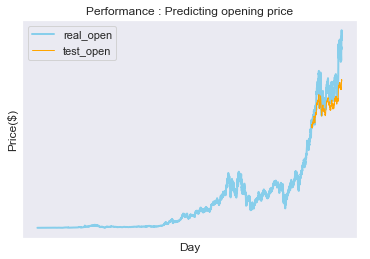

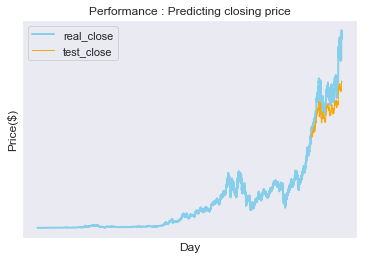

In [7]:
plt.plot( 'day', 'real_open', data=modelling, color='skyblue', linewidth=2)
plt.plot( 'day', 'test_open', data=modelling, color='orange', linewidth=1)
plt.grid(b=None)
plt.legend()
# Add title and axis names
plt.title('Performance : Predicting opening price')
plt.xlabel('Day')
plt.ylabel('Price($)')
plt.xticks([])
plt.yticks([])
plt.show()

plt.plot( 'day', 'real_close', data=modelling, color='skyblue', linewidth=2)
plt.plot( 'day', 'test_close', data=modelling, color='orange', linewidth=1)
plt.grid(b=None)
plt.legend()
# Add title and axis names
plt.title('Performance : Predicting closing price')
plt.xlabel('Day')
plt.ylabel('Price($)')
plt.xticks([])
plt.yticks([])
plt.rcParams["figure.figsize"] = [36,29]
plt.show()

In [15]:
import pygsheets
#authorization
gc = pygsheets.authorize(service_file='bigdatacdh.json')

#open the google spreadsheet (where 'PY to Gsheet Test' is the name of my sheet)
sh = gc.open('prediction')

#select the first sheet 
wks = sh[0]

#update the first sheet with df, starting at cell B2. 
wks.set_dataframe(prediction,(1,1))